# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">2. Model Training for Adultincome Dataset</p>

***Problem Statement***: The Goal is to predict  whetehr a person has an income of more than 50K a yar or not. This is basically a binary classifiaction problem whether a person is classified into the =<50k or >50k

# Loading the necessary Libraries

In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# To handle imbalanced dataset
from imblearn.over_sampling import SMOTE

# Importing performance metrics - accuracy, Classification report, confusion matrix
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

from sklearn.model_selection import RandomizedSearchCV

import warnings

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Read the Dataset</p>

In [3]:
df = pd.read_csv('data/income.csv',na_values=[" ?"])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


1. We can observe that education-num and education are the same variables with different data types. We can drop any one of them and also Final Weight- Highly Discrete Data so not useful
2. We have categorical and numerical variables.



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  country         31978 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df=df.drop(['education-num','fnlwgt'], axis=1)

In [6]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
# df.fillna(method = 'ffill', inplace = True)

df["occupation"] = df["occupation"].fillna(df["occupation"].mode()[0])
df["workclass"] = df["workclass"].fillna(df["workclass"].mode()[0])
df["country"] = df["country"].fillna(df["country"].mode()[0])

In [8]:
#Shape of dataset
df.shape

(32561, 13)

In [9]:
df.isnull().sum()

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
country           0
salary            0
dtype: int64

In [10]:
df.duplicated().sum()

3591

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
#Shape of dataset
df.shape

(28970, 13)

In [13]:
## distribution of two classes
df['salary'].value_counts()


 <=50K    21790
 >50K      7180
Name: salary, dtype: int64

dataset is imbalanced

C:\Users\91807\AppData\Local\Temp\ipykernel_20264\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

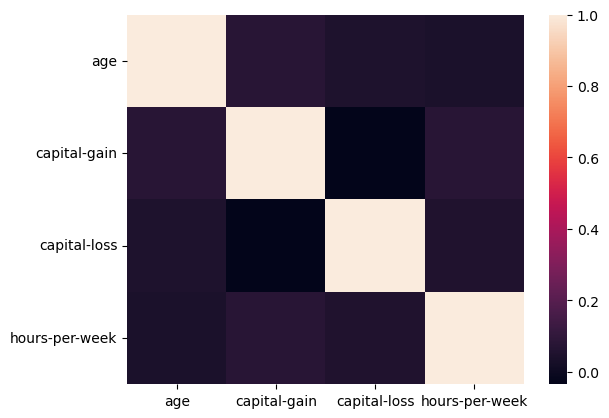

In [14]:
sns.heatmap(df.corr())

In [15]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 4 numerical features : ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

We have 9 categorical features : ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'country', 'salary']


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Preparing X and Y variable</p>

In [16]:
X = df.drop(columns=['salary'],axis=1)
y = df['salary']

In [17]:
X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [18]:
y

0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
32554      >50K
32555     <=50K
32556     <=50K
32558     <=50K
32560      >50K
Name: salary, Length: 28970, dtype: object

In [19]:
X.shape

(28970, 12)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Creating Data Transformation Pipeline</p>

### Creating Pipeline with Column Transformer

In [20]:
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('OneHotEncoder',OneHotEncoder()),
                ("scaler",StandardScaler(with_mean=False))
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

In [21]:
X=preprocessor.fit_transform(X)


In [22]:
X.shape

(28970, 103)

In [23]:
# Encoding the Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[0 0 0 ... 0 0 1]


In [24]:
y.shape

(28970,)

In [27]:
y=y.reshape(28970,1)

In [28]:
y.shape

(28970, 1)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Train Test Split</p>

In [ ]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

In [ ]:
# Addressing class imbalance with SMOTE
print("Addressing class imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
print(X_train)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Create an Evaluate Function to give all metrics after model Training</p>

In [ ]:
def evaluate_model(true, predicted):
    cm = confusion_matrix(true, predicted)
    cf = classification_report(true,predicted)
    ac = accuracy_score(true,predicted)
    
    return cm, cf, ac,
    

In [ ]:
models ={
    "Logistic Regression": LogisticRegression(random_state = 42),
    "Kneigbors": KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
    "SVC": SVC(kernel = 'rbf', random_state = 42),
    "DT": DecisionTreeClassifier(criterion = 'entropy', random_state = 42),
    "RFC": RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42),
    "AdaBoost":AdaBoostClassifier(n_estimators=100,learning_rate=1),
    "xgb":XGBClassifier()
    
    
}

model_list = []
score_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) #train model
    
    #make prediction
    y_train_pred = model.predict(X_train)
    y_test_pred= model.predict(X_test)
    
    #Evaluate Train and test dataset
    model_train_cm , model_train_cf,model_train_ac = evaluate_model(y_train, y_train_pred)
    model_test_cm , model_test_cf,model_test_ac = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    print('Model performance for training set')
    print("- Confusion Matrix\n",model_train_cm)
    print("- Classification Report\n",model_train_cf)
    print("- Accuracy Score {:.4f}".format(model_train_ac))    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Confusion Matrix\n", model_test_cm)
    print("- Classification Report\n", model_test_cf)
    print("- Accuracy Score: {:.4f}".format(model_test_ac))    
    score_list.append(model_test_ac)
    
    print('='*35)
    print('\n')
    
    
    

In [ ]:
pd.DataFrame(list(zip(model_list, score_list)), columns=['Model Name', 'Accuracy']).sort_values(by=["Accuracy"],ascending=False)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Hyperparameter Tuning </p>

### Definition to print evaluated model results

In [ ]:
def print_evaluated_results(model,X_train,y_train,X_test,y_test):
    ytrain_pred = model.predict(X_train)
    ytest_pred = model.predict(X_test)
    
    #Evaluate Train and test dataset
    model_train_cm , model_train_cf,model_train_ac = evaluate_model(y_train, y_train_pred)
    model_test_cm , model_test_cf,model_test_ac = evaluate_model(y_test, y_test_pred)
    
    #printing results
    print('Model performance for training set')
    print("- Confusion Matrix\n",model_train_cm)
    print("- Classification Report\n",model_train_cf)
    print("- Accuracy Score {:.4f}".format(model_train_ac))    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Confusion Matrix\n", model_test_cm)
    print("- Classification Report\n", model_test_cf)
    print("- Accuracy Score: {:.4f}".format(model_test_ac))    
    
    

##### Tuning Decision Tree

In [ ]:
#initiasing DecisionTree
dt=DecisionTreeClassifier()
parameter={
 'criterion':['gini','entropy','log_loss'],
  'splitter':['best','random'],
  'max_depth':[1,2,3,4,5],
  'max_features':['auto', 'sqrt', 'log2']
    
}



In [ ]:
cv=RandomizedSearchCV(dt,parameter,cv=10,scoring='accuracy')

In [ ]:
cv.fit(X_train,y_train)

In [ ]:
print(cv.best_params_)
print(cv.best_score_)

In [ ]:
# Selecting best dt model
best_cv = cv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cv,X_train,y_train,X_test,y_test)

### Tuning XGBoost

In [ ]:
# Initializing xgboost
xgb = XGBClassifier()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='accuracy',n_jobs=-1,cv=10)
rs_xgb.fit(X_train, y_train)


# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

In [ ]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,X_train,y_train,X_test,y_test)